# Grokking with a simple model on modular addition

## Preliminaries

Imports and set the CUDA device

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import random
import torch.nn as nn
import torch.nn.functional as F
import os
import sys

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    print("Using GPU", torch.cuda.get_device_name(0))
else:
    print("Using CPU")

Using CPU


In [2]:
# Seed for reproducability
SEED = 100

def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## Building the dataset
Define the dataset : addition modulo P, with a random split into train and test sets, and dataloaders with batch size

In [3]:
# Select a Prime Number
P = 59

# Create the dataset
set_seed(SEED)
add_data = []
for i in range(P):
    for j in range(P):
        add_data.append([i,j,(i+j)%P])

data = np.array(add_data)

In [4]:
# Split into train and test
TRAIN_FRACTION = 0.5
np.random.shuffle(data)
train_data = data[:int(len(data) * TRAIN_FRACTION)]
test_data = data[int(len(data) * TRAIN_FRACTION):]

# Convert to tensors and create dataloaders with batch size
BATCH_SIZE = 32
train_data = torch.tensor(train_data, dtype=torch.long, device=device)
test_data = torch.tensor(test_data, dtype=torch.long, device=device)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## Training
We use AdamW with weight decay, and cross entropy loss for FFN

In [5]:
NB_EPOCHS = 5000
LEARNING_RATE = 0.0003
WEIGHT_DECAY = 1
from rnn import RNN
from ffn import FFN
from attention import FFNAttention

set_seed(SEED)
# model = RNN().to(device)
model = FFN().to(device)
# model = FFNAttention().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Recording
REPORT_INTERVAL = 20    # How often we print
SAVE_INTERVAL = 50      # How often we save
model_folder = 'intermediary'
# Create folder if it doesn't exist
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(NB_EPOCHS):
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch in train_loader:
        x1, x2, y = batch[:,0], batch[:,1], batch[:,2]
        print(f'batch.shape:{batch.shape}, x1:{batch[:,0]}, x2:{batch[:,1]}, y:{batch[:,2]}')
        print(f'Shapes: x1:{batch[:,0].shape}')
        output = model(x1,x2)
        print(f'Output Shape: {output.shape}\nOutput: {output}')
        print(y.shape)
        break
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == y).sum().item()
    break

    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    train_acc /= len(train_data)
    train_acc_history.append(train_acc)
    
    # Testing phase
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        for batch in test_loader:
            x1, x2, y = batch[:,0], batch[:,1], batch[:,2]
            output = model(x1,x2)
            loss = criterion(output, y)
            test_loss += loss.item()
            test_acc += (output.argmax(dim=1) == y).sum().item()
        
        test_loss /= len(test_loader)
        test_loss_history.append(test_loss)
        test_acc /= len(test_data)
        test_acc_history.append(test_acc)
        
    if epoch % REPORT_INTERVAL == 0:
        print(f"{epoch}/{NB_EPOCHS}: Train loss={train_loss:.4f}, acc={100*train_acc:.1f}%  /  Test loss={test_loss:.4f}, acc={100*test_acc:.1f}%")
    
    if epoch % SAVE_INTERVAL == 0:
        # Save model in intermediary folder
        torch.save(model.state_dict(), f"{model_folder}/model_{epoch}.pth")
        
torch.save(model.state_dict(), f"model.pth")

batch.shape:torch.Size([32, 3]), x1:tensor([28, 22,  5, 16, 26,  8, 31, 52, 49,  9, 21, 30, 52, 56, 37, 35, 22,  1,
        21, 52,  5, 20, 54, 53,  1, 15, 46, 11, 34, 34,  5, 36]), x2:tensor([18, 47, 53, 41, 54, 32, 50, 51,  7, 31, 55, 41, 13, 38, 17, 12, 57, 44,
        56, 40, 27, 24, 15, 29, 58, 40, 54, 34,  8, 56, 42,  8]), y:tensor([46, 10, 58, 57, 21, 40, 22, 44, 56, 40, 17, 12,  6, 35, 54, 47, 20, 45,
        18, 33, 32, 44, 10, 23,  0, 55, 41, 45, 42, 31, 47, 44])
Shapes: x1:torch.Size([32])
Output Shape: torch.Size([32, 59])
Output: tensor([[ 0.0642, -0.0324,  0.0642,  ..., -0.0698,  0.0648,  0.1039],
        [-0.0255,  0.0580, -0.0122,  ...,  0.0120,  0.1576,  0.0299],
        [-0.0998, -0.0511, -0.1081,  ...,  0.0864,  0.1205,  0.0133],
        ...,
        [ 0.1364, -0.0634, -0.0098,  ..., -0.0625,  0.1398,  0.0004],
        [-0.1323, -0.0053, -0.0028,  ...,  0.0453,  0.0709, -0.0551],
        [ 0.0420,  0.0440, -0.0992,  ..., -0.0467,  0.0429,  0.0066]],
       grad_fn=<A

In [6]:
torch.save(model.state_dict(), f"model.pth")

## Results

Plot the evolution of accuracy and loss during training

ValueError: x and y must have same first dimension, but have shapes (5000,) and (0,)

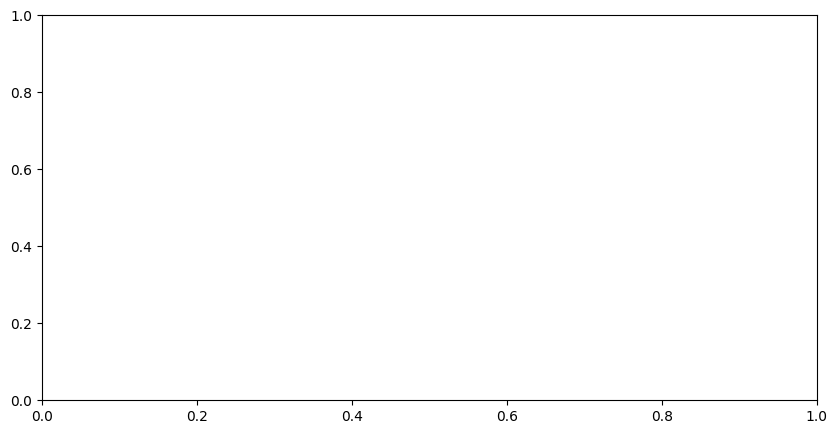

In [7]:
NB_EPOCH_PLOT = 2500

# Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, NB_EPOCHS + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, NB_EPOCHS + 1), test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Log(Loss)')
plt.yscale('log')
plt.legend()
plt.savefig('loss.png', dpi=300)
plt.xlim(0,NB_EPOCH_PLOT)
plt.savefig('loss_zoom.png', dpi=300)


# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, NB_EPOCHS + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, NB_EPOCHS + 1), test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png', dpi=300)
plt.xlim(0,NB_EPOCH_PLOT)
plt.savefig('accuracy_zoom.png', dpi=300)